In [13]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ncx2, sampling
from scipy.optimize import minimize
from interpolating_match import create_min_max_interp, SNR2ecc

The ncx2 distribution gives us the distribution of observed SNRs (squared) given the true SNR (squared) as the non central parameter. What we have is one measurementof an observed SNR, so we want to turn this around and get a probability distribution on possible true SNRs.

We do this by generating many (linear spaced in SNR) values of the non central parameter, and calculating the value of the pdf for each, evaluated at the measured SNR. These serve as weights which we use to reject or accept each sample, resulting in a distribution on the non central parameter, or equivalently the true SNR of the signal.

# Development

In [51]:
bound_tol = 10**-3
df = 2
obs_SNR = 2
n = 10**6

In [52]:
def calc_weights(proposals, obs_SNR, df):
    return ncx2.pdf(obs_SNR**2, df, proposals**2)

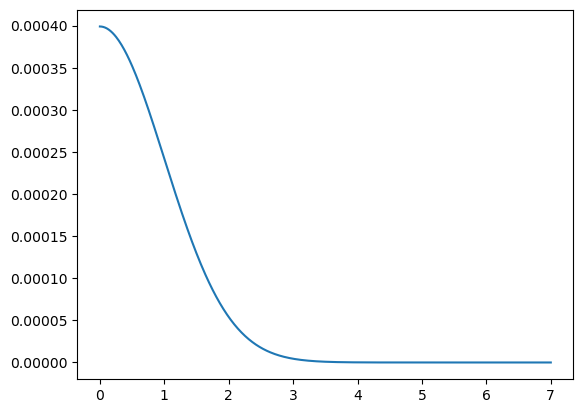

In [53]:
ncs = np.linspace(0, 7, 501)
weights = calc_weights(ncs, 0.001, 3)
plt.plot(ncs, weights)

In [54]:
# Calculate maximum possible weight and upper bound
max_weight_result = minimize(lambda x: -calc_weights(x, obs_SNR, df), obs_SNR)
max_weight = -max_weight_result['fun']
max_weight_nc_sqrt = max_weight_result['x'][0]
upper_bound = minimize(lambda x: np.abs(calc_weights(x, obs_SNR, df)/max_weight - bound_tol)/bound_tol, max_weight_nc_sqrt+1, bounds=[(0,None)])['x'][0]
print(max_weight)
print(upper_bound)

0.10829116126451947
5.557050090218076


In [55]:
proposals = np.linspace(0, upper_bound, n)
weights = calc_weights(proposals, obs_SNR, df)/max_weight

(array([205988.,  51050.,  33298.,  25577.,  21200.,  18374.,  16402.,
         14957.,  13860.,  13008.,  12338.,  11807.,  11386.,  11058.,
         10809.,  10628.,  10512.,  10459.,  40833.,  47437.,  34804.,
         31081.,  29533.,  29085.,  29455.,  30663.,  33000.,  37322.,
         46567., 107509.]),
 array([0.001 , 0.0343, 0.0676, 0.1009, 0.1342, 0.1675, 0.2008, 0.2341,
        0.2674, 0.3007, 0.334 , 0.3673, 0.4006, 0.4339, 0.4672, 0.5005,
        0.5338, 0.5671, 0.6004, 0.6337, 0.667 , 0.7003, 0.7336, 0.7669,
        0.8002, 0.8335, 0.8668, 0.9001, 0.9334, 0.9667, 1.    ]),
 [<matplotlib.patches.Polygon at 0x7fd0feeaa3b0>])

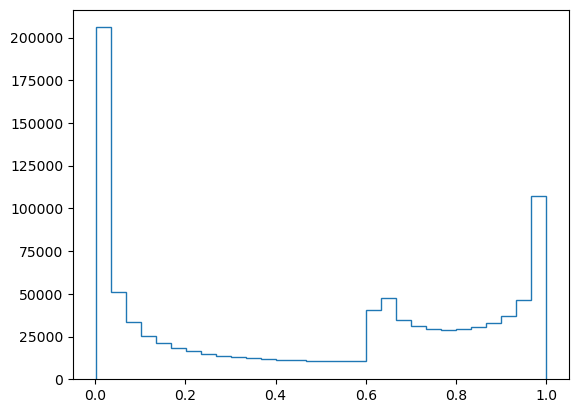

In [56]:
plt.hist(weights, histtype='step', bins=30)

485498


(array([20964., 21633., 22914., 24673., 26638., 28902., 30751., 32275.,
        33044., 33058., 32233., 30417., 28061., 25029., 21502., 18101.,
        14753., 11817.,  8802.,  6545.,  4564.,  3222.,  2174.,  1452.,
          864.,   497.,   311.,   153.,    98.,    51.]),
 array([0.        , 0.18454778, 0.36909556, 0.55364334, 0.73819112,
        0.9227389 , 1.10728668, 1.29183446, 1.47638224, 1.66093002,
        1.8454778 , 2.03002559, 2.21457337, 2.39912115, 2.58366893,
        2.76821671, 2.95276449, 3.13731227, 3.32186005, 3.50640783,
        3.69095561, 3.87550339, 4.06005117, 4.24459895, 4.42914673,
        4.61369451, 4.79824229, 4.98279007, 5.16733785, 5.35188563,
        5.53643341]),
 [<matplotlib.patches.Polygon at 0x7fd0fed1eb90>])

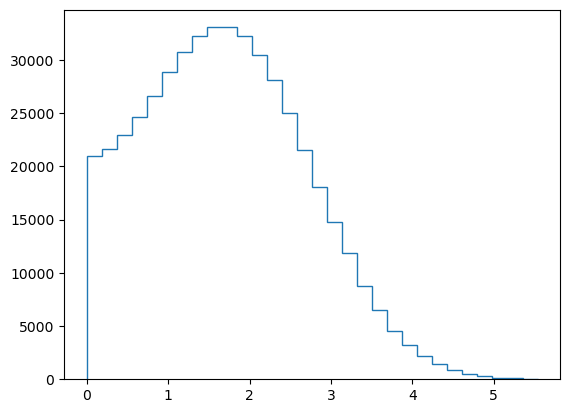

In [57]:
accepts = np.random.uniform(size=n)
samples = proposals[weights>=accepts]
print(len(samples))
plt.hist(samples, histtype='step', bins=30)

# Comparing to previous incorrect implementation

In [58]:
def SNR_samples(obs_SNR, df, n, bound_tol=10**-3):

    # Calculate maximum possible weight and upper bound
    max_weight_result = minimize(lambda x: -calc_weights(x, obs_SNR, df), obs_SNR)
    max_weight = -max_weight_result['fun']
    max_weight_nc_sqrt = max_weight_result['x'][0]
    upper_bound = minimize(lambda x: np.abs(calc_weights(x, obs_SNR, df)/max_weight - bound_tol)/bound_tol, max_weight_nc_sqrt+1, bounds=[(0,None)])['x'][0]

    # Generate proposal samples and calculate respective weights
    proposals = np.linspace(0, upper_bound, n)
    weights = calc_weights(proposals, obs_SNR, df)/max_weight

    # Accept or reject weights according to weights
    accepts = np.random.uniform(size=n)
    samples = proposals[weights>=accepts]

    return samples

def SNR_samples_OLD(obs_SNR, df, n):

    # Define distribution class
    class SNR_rv():
        def pdf(self, x):
            return ncx2.pdf(x, df, obs_SNR**2)
        def cdf(self, x):
            return ncx2.cdf(x, df, obs_SNR**2)
    
    # Generate samples
    rv = SNR_rv()
    sample_gen = sampling.NumericalInversePolynomial(rv, center=obs_SNR, domain=(0.000001, np.inf))
    samples = sample_gen.rvs(size=n)
    samples = np.sqrt(samples)

    return samples

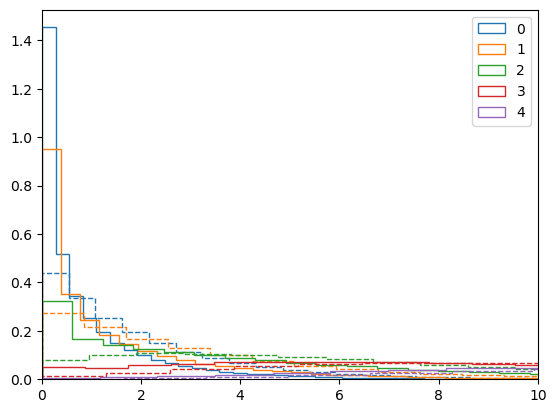

In [60]:
df = 2
n = 10**6
obs_SNRs = np.linspace(0, 4, 5)

for i, obs_SNR in enumerate(obs_SNRs):
    samples = SNR_samples(obs_SNR, df, n)
    samples_OLD = SNR_samples_OLD(obs_SNR, df, n)
    plt.hist(samples**2, density=True, histtype='step', bins=50, color=f'C{i}', label=str(int(obs_SNR)))
    plt.hist(samples_OLD**2, density=True, histtype='step', bins=50, color=f'C{i}', ls='dashed')
plt.xlim(0, 10)
plt.legend()

/tmp/ipykernel_1038008/1941314624.py:7: RuntimeWarning: invalid value encountered in divide
  upper_bound = minimize(lambda x: np.abs(calc_weights(x, obs_SNR, df)/max_weight - bound_tol)/bound_tol, max_weight_nc_sqrt+1, bounds=[(0,None)])['x'][0]
/tmp/ipykernel_1038008/1941314624.py:11: RuntimeWarning: invalid value encountered in divide
  weights = calc_weights(proposals, obs_SNR, df)/max_weight
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:1411: RuntimeWarning: invalid value encountered in subtract
  return sc.xlogy(df/2.-1, x) - x/2. - sc.gammaln(df/2.) - (np.log(2)*df)/2.
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:624: RuntimeWarning: invalid value encountered in 

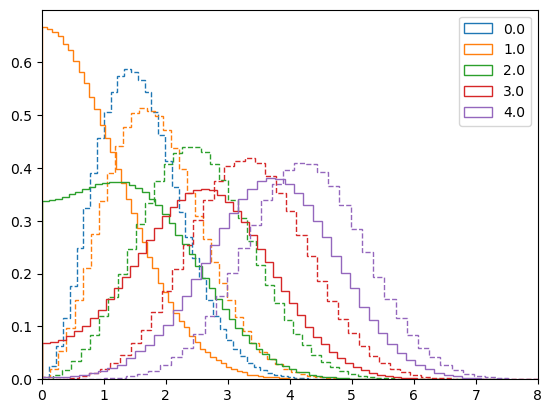

In [34]:
df = 3
n = 10**6
obs_SNRs = np.linspace(0, 4, 5)

for i, obs_SNR in enumerate(obs_SNRs):
    samples = SNR_samples(obs_SNR, df, n)
    samples_OLD = SNR_samples_OLD(obs_SNR, df, n)
    plt.hist(samples, density=True, histtype='step', bins=50, color=f'C{i}', label=str(int(obs_SNR)))
    plt.hist(samples_OLD, density=True, histtype='step', bins=50, color=f'C{i}', ls='dashed')
plt.xlim(0, 8)
plt.legend()

/tmp/ipykernel_1038008/3900839727.py:7: RuntimeWarning: invalid value encountered in divide
  upper_bound = minimize(lambda x: np.abs(calc_weights(x, obs_SNR, df)/max_weight - bound_tol)/bound_tol, max_weight_nc_sqrt+1, bounds=[(0,None)])['x'][0]
/tmp/ipykernel_1038008/3900839727.py:11: RuntimeWarning: invalid value encountered in divide
  weights = calc_weights(proposals, obs_SNR, df)/max_weight


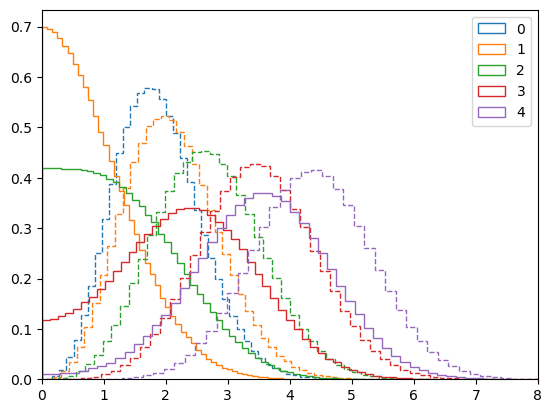

In [44]:
df = 4
n = 10**6
obs_SNRs = np.linspace(0, 4, 5)

for i, obs_SNR in enumerate(obs_SNRs):
    samples = SNR_samples(obs_SNR, df, n)
    samples_OLD = SNR_samples_OLD(obs_SNR, df, n)
    plt.hist(samples, density=True, histtype='step', bins=50, color=f'C{i}', label=str(int(obs_SNR)))
    plt.hist(samples_OLD, density=True, histtype='step', bins=50, color=f'C{i}', ls='dashed')
plt.xlim(0, 8)
plt.legend()

This does not work for a measured SNR of exactly zero for degrees of freedom of three or more. This is because the value of the ncx2 pdf is zero at zero for all non central parameter values. This is not an issue however as it is infinitesimally unlikely to actually measure zero.

Let's take a look at what percentage of samples we keep for a range of observed SNRs and degrees of freedom.

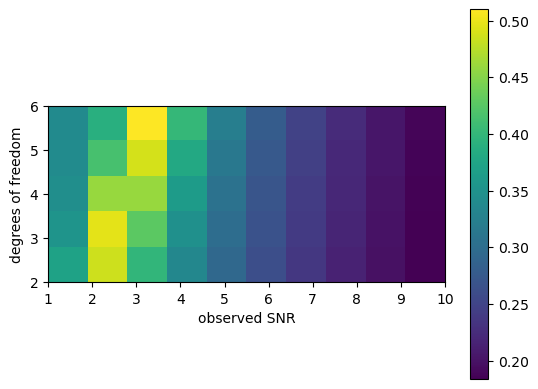

In [49]:
n = 10**6
dfs = np.linspace(2,6,5)
obs_SNRs = np.linspace(1, 10, 10)
fractions = []
for df in dfs:
    fractions.append([])
    for obs_SNR in obs_SNRs:
        samples = SNR_samples(obs_SNR, df, n)
        fractions[-1].append(len(samples)/n)
plt.imshow(fractions, origin='lower', extent=[1,10,2,6])
plt.ylabel('degrees of freedom')
plt.xlabel('observed SNR')
plt.colorbar()

The fraction of samples accepted is relatively independent of the degrees of freedom, mainly depending on the value of the observed SNR. The highest fraction are rejected at higher observed SNRs due to the lower bound of the proposal samples always being zero, however even an acceptance rate of 0.2 still gives plenty of samples and it is rather unlikely we will see signals with this much power in the higher harmonics (with current detectors).

# Aside

As an aside, I am curious what the recovered eccentricity distribution would look like with a uniform distribution on SNR.

In [8]:
# Load grid data
with open(os.path.join('grid_data', 'dataslot_48', 'all_matches'), 'rb') as fp:
        grid_data = pickle.load(fp)
    
# Find min and max
for chirp in grid_data.keys():
    for key in list(grid_data[chirp].keys()):
        if key not in ['fid_params', 'e_vals', 'ovlps', 'ovlps_perp'] and 'phase' not in key:
            grid_data[chirp][f'{key}_max'] = np.nanmax(np.array(grid_data[chirp][key]), axis=1)
            grid_data[chirp][f'{key}_min'] = np.nanmin(np.array(grid_data[chirp][key]), axis=1)

# Compute interpolation objects
interp_dict = {}
for key in ['h1_h0', 'h1_h-1_h0', 'h1_h-1_h2_h0', 'h1_h-1_h0_pc']:
    interp_dict[key] = create_min_max_interp(grid_data, list(grid_data.keys())[1], key)

(0.0, 0.4)

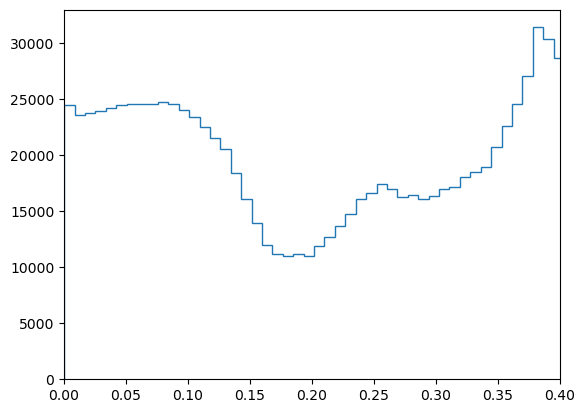

In [16]:
match_key = 'h1_h-1_h0_pc'
interps = interp_dict[match_key]
match_samples = np.linspace(0, 0.4, 10**6)
ecc_samples = SNR2ecc(match_samples, list(grid_data.keys())[1], interps, max_ecc=0.4, scaling_norms=[10, 0.035], upper_lenience=0.05)
plt.hist(ecc_samples, histtype='step', bins=50)
plt.xlim(0, 0.4)

Work on enforcing a flat prior on eccentricity is continued in flat_ecc_prior.ipynb.